In [1]:
import numpy as np
import tensorflow as tf

MODEL = "network_20190906-160604.ckpt"
batch_size = 1
dataset_size = 3902
longest = 16384

model = tf.keras.models.load_model(MODEL)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16384, 20)    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 16384, 20, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16384, 1, 128 2688        reshape[0][0]                    
________________________________________________________________________

## Load dataset

In [2]:
def onehot(seq):
    """Return the amino acid sequence as one hot coded numpy array"""
    oh = np.zeros([longest, 20])

    for i, j in enumerate(seq):
        oh[i][aa2int[j]] = 1

    return oh

aa1 = list("ACDEFGHIKLMNPQRSTVWY")
aa2int = dict((c, i) for i, c in enumerate(aa1))

def read_file(filename):
    with open(filename, "r") as f:
        while True:
            d = f.readline().replace('\n', '')
            
            if d == '': break
            
            d = d.split(";")
        
            yield d[0], onehot(d[0]), 1.0 if d[1] == '1' else 0.0

test_data = [data for data in read_file("data_split_1_test_20190807-102903.dat")]

print(len(test_data))

Seqtest = []
Xtest = np.zeros((len(test_data),) + test_data[0][1].shape)
Ytest = np.zeros((len(test_data),))
for i in range(len(test_data)):
    Seqtest.append(test_data[i][0])
    Xtest[i] = test_data[i][1]
    Ytest[i] = test_data[i][2]

3902


In [3]:
Seqallergens = []
Xallergens = []
Yallergens = []

for i in range(len(test_data)):
    if Ytest[i] > 0:
        Seqallergens.append(Seqtest[i])
        Xallergens.append(Xtest[i])
        Yallergens.append(Ytest[i])

Xallergens = np.array(Xallergens)
Yallergens = np.array(Yallergens)

print(len(Xallergens))

413


In [4]:
from math import ceil

print(Xtest.shape)

Ypred = model.predict(Xtest, batch_size=2)

(3902, 16384, 20)


## ROC methods

In [16]:
def confusion_matrix(Xs, Ys_real, Ys_pred, threshold=0.0, channel=0):
    # Convert the predicted values into a one-hot-encoding
    predicted = (Ys_pred > threshold).transpose()
    real = Ys_real > threshold
    
    not_predicted = np.logical_not(predicted)
    not_real = np.logical_not(real)
    
    TP = np.logical_and(predicted, real).sum()
    TN = np.logical_and(not_predicted, not_real).sum()
    FP = np.logical_and(predicted, not_real).sum()
    FN = np.logical_and(not_predicted, real).sum()
    
    return TP, TN, FP, FN

def rates(Xs, Ys_real, Ys_pred, threshold=0.0, channel=0):
    TP, TN, FP, FN = confusion_matrix(Xs, Ys_real, Ys_pred, threshold=threshold, channel=channel)        
    return TP / (TP + FN), TN / (TN + FP), FP / (FP + TN), FN / (FN + TP)

def roc_curve(Xs, Ys_real, Ys_pred, numThresholds=100, channel=0):
    curve = { 0.0: 0.0, 1.0: 1.0 }
    for thresh in np.linspace(0.0, 1.0, numThresholds):
        tpr, _, fpr, _ = rates(Xs, Ys_real, Ys_pred, threshold=thresh, channel=channel)
        curve[fpr] = tpr
    
    # Sort the curve by the FPR values
    sorted_curve = list(sorted(list(curve.items()), key=lambda x : x[0]))
    
    # Unzip the curve and return the result
    return tuple(zip(*sorted_curve))

def pr_curve(Xs, Ys_real, Ys_pred, numThresholds=100):
    curve = {}
    for thresh in np.linspace(0.0, 1.0, numThresholds):
        TP, TN, FP, FN = confusion_matrix(Xs, Ys_real, Ys_pred, threshold=thresh)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        curve[precision] = recall
    
    # Sort the curve by the FPR values
    sorted_curve = list(sorted(list(curve.items()), key=lambda x : x[0]))
    
    # Unzip the curve and return the result
    return tuple(zip(*sorted_curve))

def best_threshold(Xs, Ys_real, Ys_pred, numThresholds=100):
    best = 0.0
    lastY = 0.0
    
    vs = {}
    
    for thresh in np.linspace(0.0, 1.0, numThresholds):
        tpr, _, fpr, _ = rates(Xs, Ys_real, Ys_pred, threshold=thresh)
        y = tpr + fpr - 1
        vs[thresh] = abs(y)        
        
    return min(vs, key=vs.get)

def area_under_curve(x, y):
    a = 0.0
    for i in range(len(x)-1):
        dx = x[i+1]-x[i]
        v = y[i+1]+y[i]
        if np.isnan(dx) or np.isnan(v): continue
        a += v*dx / 2.0
    return a

def plot_roc_curve(Xs, Ys_real, Ys_pred, numThresholds=100):
    curve = roc_curve(Xs, Ys_real, Ys_pred, numThresholds=numThresholds)
    #threshs = [best_threshold(Xs, Ys_real, Ys_pred, numThresholds=numThresholds, channel=channel) for channel in range(Ys_real.shape[-1])]
    auc = area_under_curve(*curve)
    
    plt.plot(curve[0], curve[1], linewidth=2.0)
    
    the_labels = [F"Allergen-net ({auc:.2f})", "Random classifier (0.5)"]
    the_labels.append("Random classifier (0.5)")
    
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend(the_labels)

C:\Users\z003v6wt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


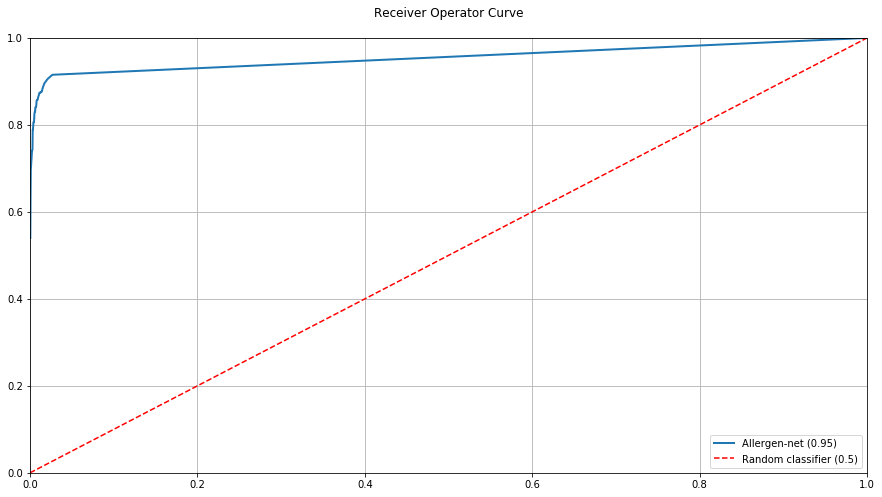

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.grid(which='both')
plt.title("Receiver Operator Curve\n")

plot_roc_curve(Xtest, Ytest, Ypred, numThresholds=1000)

In [23]:
TP, TN, FP, FN = confusion_matrix(Xtest, Ytest, Ypred, threshold=0.05)

print(F"True positive rate:   {TP / (TP + FN) * 100:>5.2f}%")
print(F"True negative rate:   {TN / (TN + FP) * 100:>5.2f}%")
print(F"False positive rate:  {FP / (FP + TN) * 100:>5.2f}%")
print(F"False negative rate:  {FN / (FN + TP) * 100:>5.2f}%")

True positive rate:   82.57%
True negative rate:   99.48%
False positive rate:   0.52%
False negative rate:  17.43%


C:\Users\z003v6wt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\z003v6wt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars


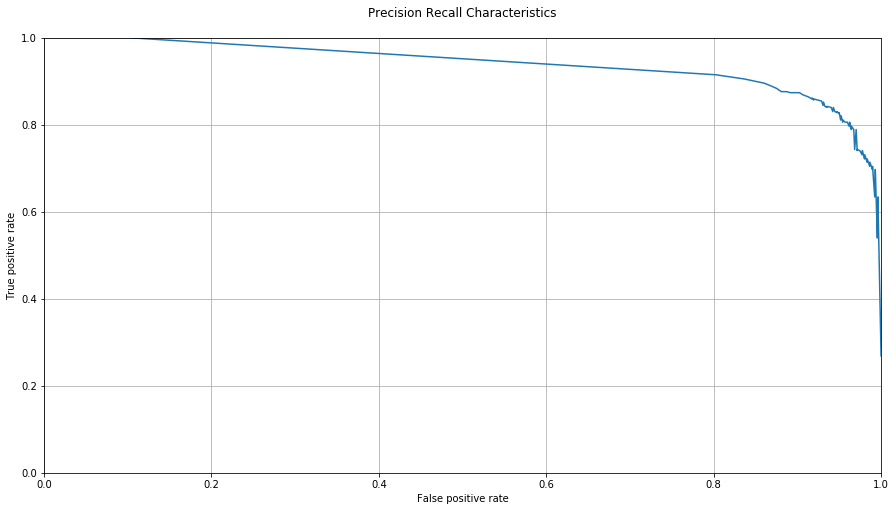

In [11]:
x,y = pr_curve(Xtest, Ytest, Ypred, numThresholds=1000)

plt.figure(figsize=(15,8))
plt.grid(which='both')
plt.title("Precision Recall Characteristics\n")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.plot(x,y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [10]:
model.evaluate(Xtest, Ytest)

3902/3902 [==============================] - 381s 98ms/sample - loss: 0.1762 - acc: 0.9677


[0.17616567150566742, 0.9677089]

In [17]:
best_threshold(Xtest, Ytest, Ypred, numThresholds=100)

C:\Users\z003v6wt\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


0.010101010101010102